In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio

from utils.ddpm import *

# Device configuration
device = torch.device('cuda:'+str(torch.cuda.device_count()-1) if torch.cuda.is_available() else 'cpu')
data_path_root = '/data/wumin/dataset/mnist/'


In [2]:
bs = 100
z_dim = 62
n_classes = 10
dim_c_dis = n_classes
dim_c_con = 2

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root=data_path_root, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_path_root, train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


In [3]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(z_dim+dim_c_dis+dim_c_con, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 1, 1, 2)

    # forward method
    def forward(self, z, c1, c2):
        x = torch.cat([z, c1, c2], dim=1)
        x =  F.leaky_relu(self.deconv1_bn(self.deconv1(x)), 0.2)
        x =  F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x =  F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x =  F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x =  F.tanh(self.deconv5(x))
        
        return x


class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)

        return x


class Dhead(nn.Module):
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(d*8, 1, 1, 1, 0)
    
    def forward(self, x):
        x = F.dropout(x, 0.3)
        return F.sigmoid(self.conv1(x))


class Qhead(nn.Module):
    def __init__(self, d=128, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(d*8, d, 1, 1, 0)
        self.conv1_bn = nn.BatchNorm2d(d)
    
        self.conv_disc = nn.Conv2d(d, dim_c_dis, 1, 1, 0)
        self.conv_mu = nn.Conv2d(d, dim_c_con, 1, 1, 0)
        self.conv_var = nn.Conv2d(d, dim_c_con, 1, 1, 0)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2, inplace=True)
        disc_logits = self.conv_disc(x).squeeze() # TODO softmax?
        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())
        
        return disc_logits, mu, var
        
        
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
    
def weight_init(net, mean, std):
    for m in net._modules:
        normal_init(net._modules[m], mean, std)

In [4]:
G, D = Generator().to(device), Discriminator().to(device)
head_q, head_d = Qhead().to(device), Dhead().to(device)
weight_init(G, 0, 0.02)
weight_init(D, 0, 0.02)
weight_init(head_q, 0, 0.02)
weight_init(head_d, 0, 0.02)


In [5]:
G,D,head_q,head_d

(Generator(
   (deconv1): ConvTranspose2d(74, 1024, kernel_size=(4, 4), stride=(1, 1))
   (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (deconv5): ConvTranspose2d(128, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
 ),
 Discriminator(
   (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2,

In [6]:
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam([{'params': G.parameters()}, {'params': head_q.parameters()}], lr = lr)
D_optimizer = optim.Adam([{'params': D.parameters()}, {'params': head_d.parameters()}], lr = lr)
y_real, y_fake = torch.ones(bs).to(device), torch.zeros(bs).to(device)
def D_train(x):
    #=======================Train the discriminator=======================#
    D_optimizer.zero_grad()

    # train discriminator on real
    x_real = x.to(device)

    D_output = D(x_real)
    head_d_out = head_d(D_output).squeeze()
    D_real_loss = criterionD(head_d_out, y_real)
    # D_real_score = D_output

    # train discriminator on fake
    z = torch.randn((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)
    c1 = F.one_hot(torch.randint(0, n_classes, [bs]), num_classes=n_classes).view(bs, dim_c_dis, 1, 1).to(device)
    c2 = ((torch.rand(bs, 2, 1, 1) - 0.5) * 2).to(device)
    x_fake = G(z, c1, c2)

    D_output = D(x_fake)
    head_d_out = head_d(D_output).squeeze()
    D_fake_loss = criterionD(head_d_out, y_fake)
    # D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G_optimizer.zero_grad()

    z = torch.randn((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)
    c1 = F.one_hot(torch.randint(0, n_classes, [bs]), num_classes=n_classes).view(bs, dim_c_dis, 1, 1).to(device)
    c2 = ((torch.rand(bs, 2, 1, 1) - 0.5) * 2).to(device)
    
    G_output = G(z, c1, c2)
    D_output = D(G_output)
    head_d_out = head_d(D_output).squeeze()
    logits, mu, var = head_q(D_output)
    
    loss_d = criterionD(head_d_out, y_real)
    loss_Q_dis = criterionQ_dis(logits, torch.topk(c1.squeeze(), 1)[1].squeeze())
    loss_Q_con = criterionQ_con(c2.squeeze(), mu, var) * 0.1  # λ_con = 0.1 
    
    # gradient backprop & optimize ONLY G's parameters
    G_loss = loss_d + loss_Q_dis + loss_Q_con
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()


In [7]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

test_z = torch.zeros((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)
c1 = torch.tensor([j for _ in range(n_classes) for j in range(bs//n_classes)])
c1 = F.one_hot(c1, num_classes=n_classes).view(bs, dim_c_dis, 1, 1).to(device)
c2_1 = torch.zeros(bs, 1, 1, 1).to(device)
c2_2 = torch.zeros(bs, 1, 1, 1).to(device)
tmp = torch.linspace(-1, 1, bs//n_classes)
for i in range(bs//n_classes):
    for j in range(n_classes):
        c2_1[i*n_classes + j, 0, 0, 0] = tmp[i]
        

def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    with torch.no_grad():
        c2 = torch.cat([c2_1, c2_2], dim=1)
        generated = G(test_z, c1, c2)
        save_image(generated.view(generated.size(0), 1, 28, 28),
                   './samples/infogan/sample_c1_c2_1_epoch_{}.png'.format(num_epoch), nrow=n_classes)

        c2 = torch.cat([c2_2, c2_1], dim=1)
        generated = G(test_z, c1, c2)
        save_image(generated.view(generated.size(0), 1, 28, 28),
                   './samples/infogan/sample_c1_c2_2_epoch_{}.png'.format(num_epoch), nrow=n_classes)


In [8]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    # display the training losses as epoch increasing
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=5)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [9]:
n_epoch = 20
print('training start!')
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.FloatTensor(D_losses).mean(), torch.FloatTensor(G_losses).mean()))
    show_result(epoch)
    
    train_hist['D_losses'].append(torch.FloatTensor(D_losses).mean())
    train_hist['G_losses'].append(torch.FloatTensor(G_losses).mean())


training start!
[1/20]: loss_d: 1.335, loss_g: 1.325
[2/20]: loss_d: 1.117, loss_g: 0.989
[3/20]: loss_d: 1.123, loss_g: 1.076
[4/20]: loss_d: 1.214, loss_g: 0.984
[5/20]: loss_d: 1.256, loss_g: 0.914
[6/20]: loss_d: 1.266, loss_g: 0.879
[7/20]: loss_d: 1.278, loss_g: 0.841
[8/20]: loss_d: 1.290, loss_g: 0.816
[9/20]: loss_d: 1.304, loss_g: 0.788
[10/20]: loss_d: 1.326, loss_g: 0.755
[11/20]: loss_d: 1.336, loss_g: 0.720
[12/20]: loss_d: 1.336, loss_g: 0.705
[13/20]: loss_d: 1.332, loss_g: 0.696
[14/20]: loss_d: 1.336, loss_g: 0.682
[15/20]: loss_d: 1.337, loss_g: 0.677
[16/20]: loss_d: 1.336, loss_g: 0.672
[17/20]: loss_d: 1.337, loss_g: 0.670
[18/20]: loss_d: 1.334, loss_g: 0.668
[19/20]: loss_d: 1.341, loss_g: 0.665
[20/20]: loss_d: 1.337, loss_g: 0.660


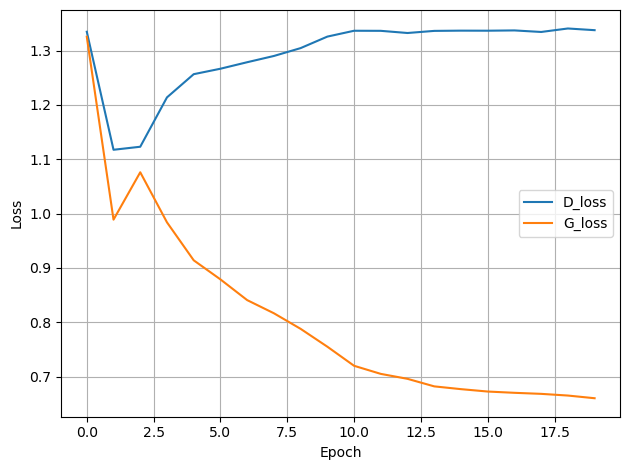

In [10]:
torch.save(G, './models/infogan_G.pth')
torch.save(D, './models/infogan_D.pth')
show_train_hist(train_hist, True, True, 'samples/infogan/history_train_losses.png')


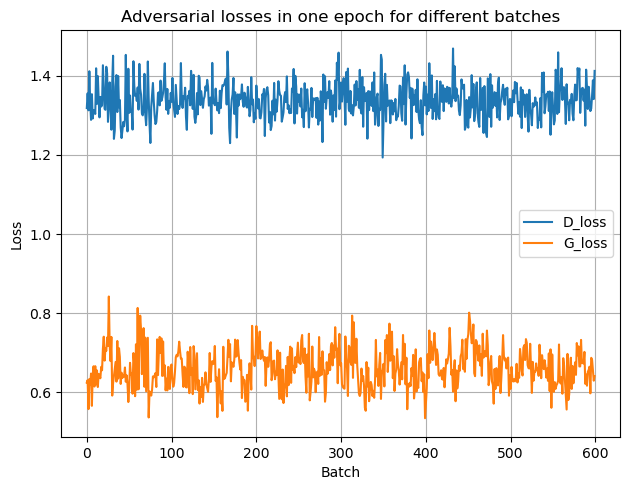

In [11]:
x = range(len(D_losses))
y1 = D_losses
y2 = G_losses

plt.plot(x, y1, label='D_loss')
plt.plot(x, y2, label='G_loss')

plt.xlabel('Batch')
plt.ylabel('Loss')

plt.legend(loc=5)
plt.grid(True)
plt.tight_layout()
plt.title('Adversarial losses in one epoch for different batches')
plt.savefig('samples/infogan/adversarial_losses.png')
plt.show()


In [12]:
images = []
for e in range(n_epoch):
    img_name = 'samples/infogan/sample_c1_c2_1_epoch_' + str(e + 1) + '.png'
    images.append(imageio.v2.imread(img_name))
imageio.mimsave('samples/infogan/generation_animation_c1_c2_1.gif', images, duration=200)

images = []
for e in range(n_epoch):
    img_name = 'samples/infogan/sample_c1_c2_2_epoch_' + str(e + 1) + '.png'
    images.append(imageio.v2.imread(img_name))
imageio.mimsave('samples/infogan/generation_animation_c1_c2_2.gif', images, duration=200)


In [23]:
test_z = torch.randn((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)
c1 = F.one_hot(torch.randint(0, 10, [bs]), num_classes=n_classes).view(bs, dim_c_dis, 1, 1).to(device)
c2 = (torch.rand(bs, dim_c_con, 1, 1)*2.0 - 1.0).to(device)
with torch.no_grad():
    generated = G(test_z, c1, c2)
    save_image(generated.view(generated.size(0), 1, 28, 28),
                './samples/infogan/sample_random.png', nrow=n_classes)